# ATP Tennis Data - Player Diff Stats + One Hot Encoding Categorial Columns + Matchup Data


In our previous notebooks, we added various match results for players leading up to our current match. 

In this notebook, we will add matchup history between player 1 and 2 to the data and see if this helps our performance. If matchup behaves like history data. I suspect that this will actually decrease our performance for our Decision Tree Model.

Matchup Data that we obtained for each player (created in this [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/6-apt_advanced_feature_engineering-history.ipynb)):

Raw:
* matchup wins
* matchup losses
* matchup games won
* matchup sets won

Percentage:
* matchup win percentage
* matchup games won percentage
* matchup sets won percentage

Diff:
* p1_matchup_games_diff
* p1_matchup_sets_diff
* p1_matchup_wins_diff



### Results from Decision Tree Classifier with player diff + one hot encoded player ID's:

```
Model Score: 0.9307224848075625

              precision    recall  f1-score   support

        Loss       0.93      0.94      0.93      7416
         Win       0.93      0.93      0.93      7394

    accuracy                           0.93     14810
   macro avg       0.93      0.93      0.93     14810
weighted avg       0.93      0.93      0.93     14810
```

# Summary of Results

Decision Tree is still our best model

Here is the results of our Decision Tree model when we added all previous matchup data to our dataset.

We ~1% drop in precision for both wins and losses and 2% recall drop for losses and 1% recall for wins drop meaning that with this data the model is worse at identifying losses

```
Model Score: 0.9187711006076975

              precision    recall  f1-score   support

        Loss       0.92      0.92      0.92      7453
         Win       0.92      0.92      0.92      7357

    accuracy                           0.92     14810
   macro avg       0.92      0.92      0.92     14810
weighted avg       0.92      0.92      0.92     14810
```

Here is the outcome when we added previous match record for each player to our dataset:
```
Model Score: 0.9177582714382174

            precision    recall  f1-score   support

      Loss       0.91      0.92      0.92      7453
       Win       0.92      0.91      0.92      7357

  accuracy                           0.92     14810
 macro avg       0.92      0.92      0.92     14810
weighted avg       0.92      0.92      0.92     14810
```

We do see a slight drop in our model precision, however, the drop is not as big as the drop from when we added all match history for both players.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, REPORT_FILE

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "diff-ohe-matchup_all"


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-diff-ohe-history5-matchup5.csv'

START_YEAR = 1998
END_YEAR = 2018

LABEL_COL = 'p1_winner'

# random seed
RSTATE = 1
N_JOBS = 4
MAX_ITER = 100



In [3]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR)

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [4]:
import re
history_columns = [col for col in X_train.columns if re.search("history", col)]

print(history_columns)

print(f'Before: X_train.shape {X_train.shape} X_test.shape {X_test.shape}')
X_train = X_train.drop(history_columns, axis=1)
X_test = X_test.drop(history_columns, axis=1)
print(f'After: X_train.shape {X_train.shape} X_test.shape {X_test.shape}')

['p1_history_games_lost', 'p1_history_games_won', 'p1_history_games_won_percentage', 'p1_history_losses', 'p1_history_sets_lost', 'p1_history_sets_won', 'p1_history_sets_won_percentage', 'p1_history_win_percentage', 'p1_history_wins', 'p2_history_games_lost', 'p2_history_games_won', 'p2_history_games_won_percentage', 'p2_history_losses', 'p2_history_sets_lost', 'p2_history_sets_won', 'p2_history_sets_won_percentage', 'p2_history_win_percentage', 'p2_history_wins', 'p1_history_win_percentage_diff', 'p1_history_games_won_percentage_diff', 'p1_history_sets_won_percentage_diff', 'p1_history_wins_diff', 'p1_history_losses_diff', 'p1_history_matches', 'p2_history_matches']
Before: X_train.shape (44429, 5293) X_test.shape (14810, 5293)
After: X_train.shape (44429, 5268) X_test.shape (14810, 5268)


In [5]:
[col for col in X_train.columns if re.search("matchup", col)]

['p1_matchup_games',
 'p1_matchup_games_won_percentage',
 'p1_matchup_losses',
 'p1_matchup_sets',
 'p1_matchup_sets_won_percentage',
 'p1_matchup_win_percentage',
 'p1_matchup_wins',
 'p2_matchup_games',
 'p2_matchup_games_won_percentage',
 'p2_matchup_losses',
 'p2_matchup_sets',
 'p2_matchup_sets_won_percentage',
 'p2_matchup_win_percentage',
 'p2_matchup_wins',
 'p1_matchup_games_diff',
 'p1_matchup_sets_diff',
 'p1_matchup_wins_diff']

# Logistic Regression

In [6]:
lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_lr = lr.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.674004051316678

              precision    recall  f1-score   support

        Loss       0.68      0.66      0.67      7453
         Win       0.67      0.68      0.68      7357

    accuracy                           0.67     14810
   macro avg       0.67      0.67      0.67     14810
weighted avg       0.67      0.67      0.67     14810

      Loss   Win
Loss  4955  2498
Win   2330  5027


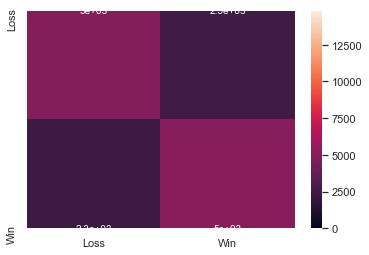

In [7]:
lr.analyze()

In [8]:
# ju.plot_2d(X_test, y_predict_lr)

In [9]:
lr.save()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# KNN

In [10]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_knn = knn.predict()

Model Score: 0.8253207292370021

              precision    recall  f1-score   support

        Loss       0.82      0.84      0.83      7453
         Win       0.83      0.81      0.82      7357

    accuracy                           0.83     14810
   macro avg       0.83      0.83      0.83     14810
weighted avg       0.83      0.83      0.83     14810

      Loss   Win
Loss  6261  1192
Win   1395  5962


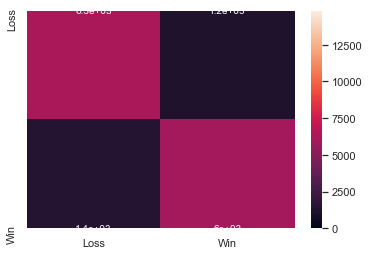

In [11]:
knn.analyze()

In [ ]:
# ju.plot_2d(X_test, y_predict_knn)

In [13]:
knn.save()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Decision Tree

In [14]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_dt = dt.predict()

Model Score: 0.9187711006076975

              precision    recall  f1-score   support

        Loss       0.92      0.92      0.92      7453
         Win       0.92      0.92      0.92      7357

    accuracy                           0.92     14810
   macro avg       0.92      0.92      0.92     14810
weighted avg       0.92      0.92      0.92     14810

      Loss   Win
Loss  6862   591
Win    612  6745


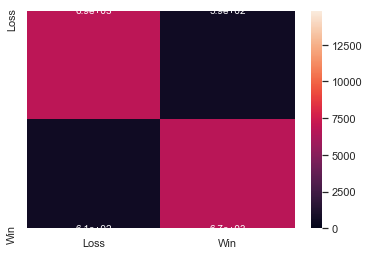

In [15]:
dt.analyze()

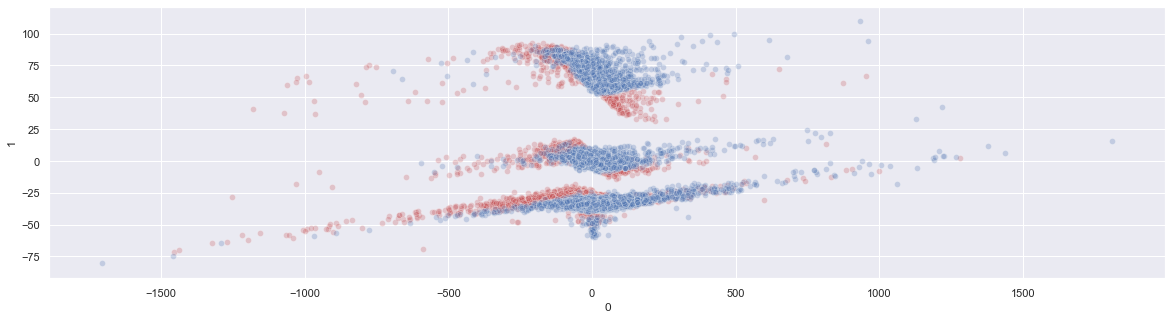

In [16]:
# ju.plot_2d(X_test, y_predict_dt)

In [17]:
dt.save()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Random Forest Classifier

In [18]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_rf = rf.predict()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.787508440243079

              precision    recall  f1-score   support

        Loss       0.77      0.83      0.80      7453
         Win       0.81      0.75      0.78      7357

    accuracy                           0.79     14810
   macro avg       0.79      0.79      0.79     14810
weighted avg       0.79      0.79      0.79     14810

      Loss   Win
Loss  6165  1288
Win   1859  5498


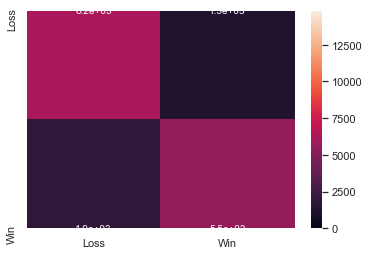

In [19]:
rf.analyze()

In [20]:
# ju.plot_2d(X_test, y_predict_rf)

In [21]:
rf.save()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Gradient Boosting

In [22]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3157           15.63m
         2           1.2579           15.29m
         3           1.2102           14.73m
         4           1.1722           14.48m
         5           1.1405           14.32m
         6           1.1058           14.18m
         7           1.0785           13.95m
         8           1.0558           13.81m
         9           1.0321           13.67m
        10           1.0159           13.54m
        20           0.8899           12.07m
        30           0.8228           10.57m
        40           0.7841            9.00m
        50           0.7554            7.49m
        60           0.7362            5.98m
        70           0.7244            4.48m
        80           0.7078            2.99m
        90           0.6799            1.49m
       100           0.6752            0.00s


Model Score: 0.8561782579338285

              precision    recall  f1-score   support

        Loss       0.84      0.88      0.86      7453
         Win       0.87      0.83      0.85      7357

    accuracy                           0.86     14810
   macro avg       0.86      0.86      0.86     14810
weighted avg       0.86      0.86      0.86     14810

      Loss   Win
Loss  6554   899
Win   1231  6126


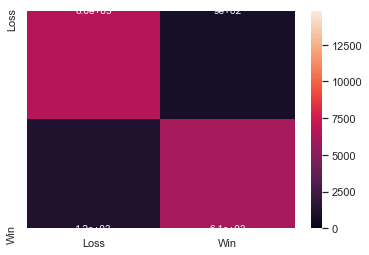

In [23]:
gb.analyze()

In [24]:
# ju.plot_2d(X_test, y_predict_gb)

In [25]:
gb.save()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# AdaBoost

In [26]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_ab = ab.predict()

Model Score: 0.7512491559756921

              precision    recall  f1-score   support

        Loss       0.73      0.79      0.76      7453
         Win       0.77      0.71      0.74      7357

    accuracy                           0.75     14810
   macro avg       0.75      0.75      0.75     14810
weighted avg       0.75      0.75      0.75     14810

      Loss   Win
Loss  5908  1545
Win   2139  5218


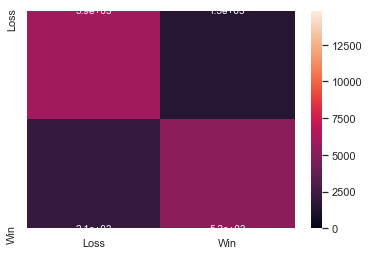

In [27]:
ab.analyze()

In [28]:
# ju.plot_2d(X_test, y_predict_ab)

In [29]:
ab.save()

/Users/vinceluk/anaconda3/envs/capstone2/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Results

* Decision Tress is still our best model, although adding this data decreased our performance to be about 1% (from diff+ohe_player performance)
* No change in performance for Ada Boost or Logistic regression or Gradient Boost
* Around 5% decrease in accuracy for KNN and Random Forest

In [3]:
report = pd.read_csv(REPORT_FILE)
report.tail(5)

,accuracy,classification_report,confusion_matrix,data_file,description,end_year,fit_time_min,model_file,model_name,predict_time_min,start_year,total_time_min
73,0.833153,"{""Loss"": {""precision"": 0.8260471204188482, ""re...","{""0"": {""0"": 6311, ""1"": 1329}, ""1"": {""0"": 1142,...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-matchup_diff,2018,0.0,../models/kneighborsclassifier-1998-2018-diff-...,KNeighborsClassifier,0.0,1998,0.0
74,0.925456,"{""Loss"": {""precision"": 0.923549032688459, ""rec...","{""0"": {""0"": 6922, ""1"": 573}, ""1"": {""0"": 531, ""...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-matchup_diff,2018,0.0,../models/decisiontreeclassifier-1998-2018-dif...,DecisionTreeClassifier,0.0,1998,0.0
75,0.791695,"{""Loss"": {""precision"": 0.7743718592964824, ""re...","{""0"": {""0"": 6164, ""1"": 1796}, ""1"": {""0"": 1289,...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-matchup_diff,2018,0.0,../models/randomforestclassifier-1998-2018-dif...,RandomForestClassifier,0.0,1998,0.0
76,0.852262,"{""Loss"": {""precision"": 0.8393708908083022, ""re...","{""0"": {""0"": 6511, ""1"": 1246}, ""1"": {""0"": 942, ...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-matchup_diff,2018,9.0,../models/gradientboostingclassifier-1998-2018...,GradientBoostingClassifier,0.0,1998,9.0
77,0.749291,"{""Loss"": {""precision"": 0.735101835554438, ""rec...","{""0"": {""0"": 5847, ""1"": 2107}, ""1"": {""0"": 1606,...",../datasets/atp_matches_1985-2019_features-dif...,diff-ohe-matchup_diff,2018,1.0,../models/adaboostclassifier-1998-2018-diff-oh...,AdaBoostClassifier,0.0,1998,1.0


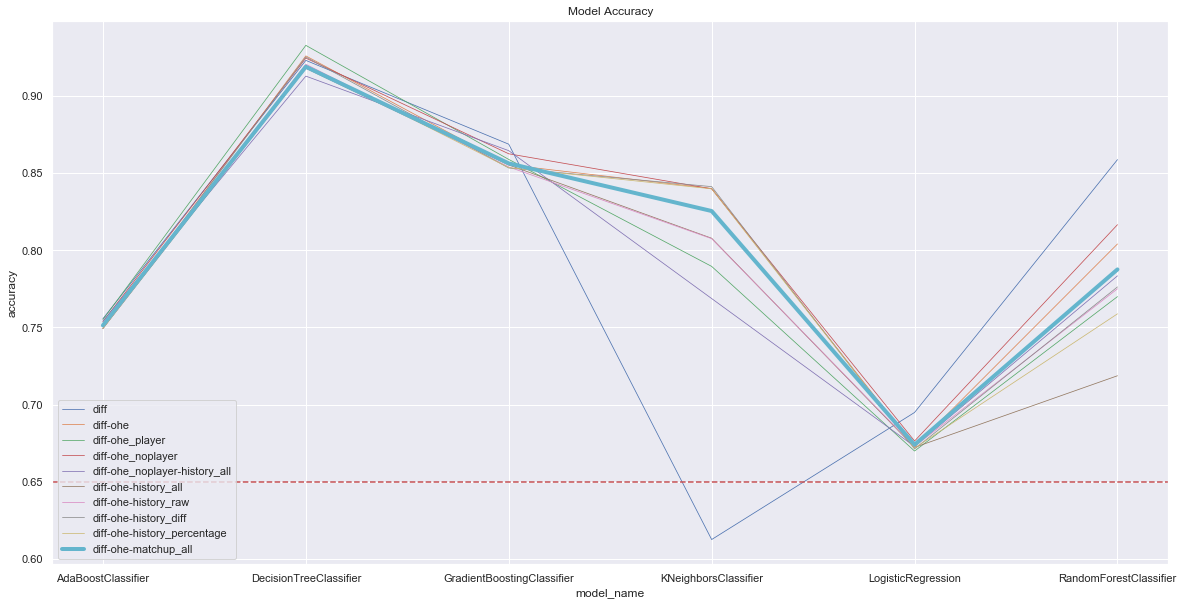

In [6]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

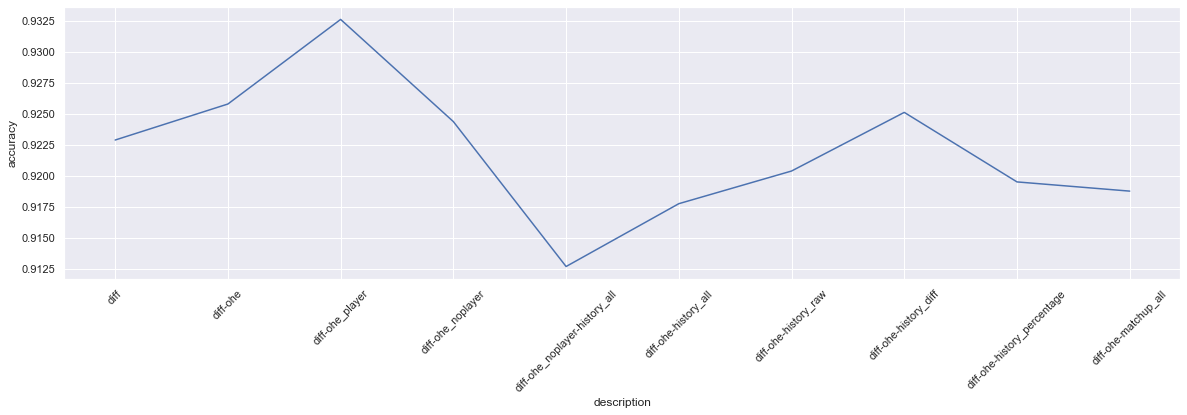

In [7]:
dt_report = report[(report.model_name == 'DecisionTreeClassifier')]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.set_label("Decision Tree Classifier Accuracy")
_ = plt.xticks(rotation=45)


# Feature Analysis

In [35]:
import shap

shap.initjs()

mw = ModelWrapper.get_model_wrapper_from_report(dt_report[dt_report.description == DESCRIPTION])


explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)
print(np.array(shap_values).shape)

(2, 14810, 5268)


In [ ]:
shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns, max_display=25)

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, title="Feature Importance")